In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(phateR))
suppressMessages(library(parallel))
suppressMessages(library(ggrepel))

In [2]:
set.seed(42)
getwd()

addArchRThreads(threads = parallel::detectCores() - 2)
addArchRGenome("hg38")

[1] "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/IntegrativeAnalysis/Cardiomyocyte/code"

Setting default number of Parallel threads to 126.

Setting default genome to Hg38.



In [3]:
## subset atac project
proj <- loadArchRProject("../data/snATAC_healthy_intermediate_damaged", showLogo = FALSE)

Successfully loaded ArchRProject!



In [4]:
## define functions
library(Rcpp)
Rcpp::sourceCpp(code='
  #include <Rcpp.h>

  using namespace Rcpp;
  using namespace std;

  // Adapted from https://github.com/AEBilgrau/correlateR/blob/master/src/auxiliary_functions.cpp
  // [[Rcpp::export]]
  Rcpp::NumericVector rowCorCpp(IntegerVector idxX, IntegerVector idxY, Rcpp::NumericMatrix X, Rcpp::NumericMatrix Y) {
    
    if(X.ncol() != Y.ncol()){
      stop("Columns of Matrix X and Y must be equal length!");
    }

    if(max(idxX)-1 > X.nrow()){
      stop("Idx X greater than nrow of Matrix X");
    }

    if(max(idxY)-1 > Y.nrow()){
      stop("Idx Y greater than nrow of Matrix Y");
    }

    // Transpose Matrices
    X = transpose(X);
    Y = transpose(Y);
    
    const int nx = X.ncol();
    const int ny = Y.ncol();

    // Centering the matrices
    for (int j = 0; j < nx; ++j) {
      X(Rcpp::_, j) = X(Rcpp::_, j) - Rcpp::mean(X(Rcpp::_, j));
    }

    for (int j = 0; j < ny; ++j) {
      Y(Rcpp::_, j) = Y(Rcpp::_, j) - Rcpp::mean(Y(Rcpp::_, j));
    }

    // Compute 1 over the sample standard deviation
    Rcpp::NumericVector inv_sqrt_ss_X(nx);
    for (int i = 0; i < nx; ++i) {
      inv_sqrt_ss_X(i) = 1/sqrt(Rcpp::sum( X(Rcpp::_, i) * X(Rcpp::_, i) ));
    }

    Rcpp::NumericVector inv_sqrt_ss_Y(ny);
    for (int i = 0; i < ny; ++i) {
      inv_sqrt_ss_Y(i) = 1/sqrt(Rcpp::sum( Y(Rcpp::_, i) * Y(Rcpp::_, i) ));
    }

    //Calculate Correlations
    const int n = idxX.size();
    Rcpp::NumericVector cor(n);
    for(int k = 0; k < n; k++){
      cor[k] = Rcpp::sum( X(Rcpp::_, idxX[k] - 1) * Y(Rcpp::_, idxY[k] - 1) ) * inv_sqrt_ss_X(idxX[k] - 1) * inv_sqrt_ss_Y(idxY[k] - 1);    } 

    return(cor);

  }'
)


Rcpp::sourceCpp(code='
  #include <Rcpp.h>
using namespace Rcpp;
using namespace std;

// [[Rcpp::export]]
Rcpp::IntegerVector determineOverlapCpp(IntegerMatrix m, int overlapCut){

  int k2 = 2 * m.ncol();
  int nr = m.nrow();
  int nUnion;
  int maxOverlap;
  IntegerVector unionVector;
  IntegerVector testVector = IntegerVector(nr);
  IntegerVector nOverlap = IntegerVector(nr);
  NumericVector maxOverlapVector = NumericVector(nr);
  IntegerVector vi;
  IntegerVector vj;

  for (int i = 1; i < nr; i++){
   
    if (i % 500 == 0) Rcpp::Rcout << "Completed Computing KNN Overlap " << i << " of " << nr << endl;
    
    for(int j = 0; j < i; j++){
      
      if(testVector(j) == 0){
        vi = m(i, _);
        vj = m(j, _);
        unionVector = union_( vi , vj );
        nUnion = unionVector.size();
        nOverlap(j) = k2 - nUnion;
      }else{
        nOverlap(j) = 0;
      }
    }

    maxOverlap = max( nOverlap );
    maxOverlapVector(i) = maxOverlap;
    if(maxOverlap > overlapCut){
      testVector(i) = -1;
    }

  }

  return testVector;

}'
)

Creating Trajectory Group Matrix..

Smoothing...

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1f9ca84f0716c0-Date-2022-02-17_Time-15-05-01.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1f9ca84f0716c0-Date-2022-02-17_Time-15-05-01.log



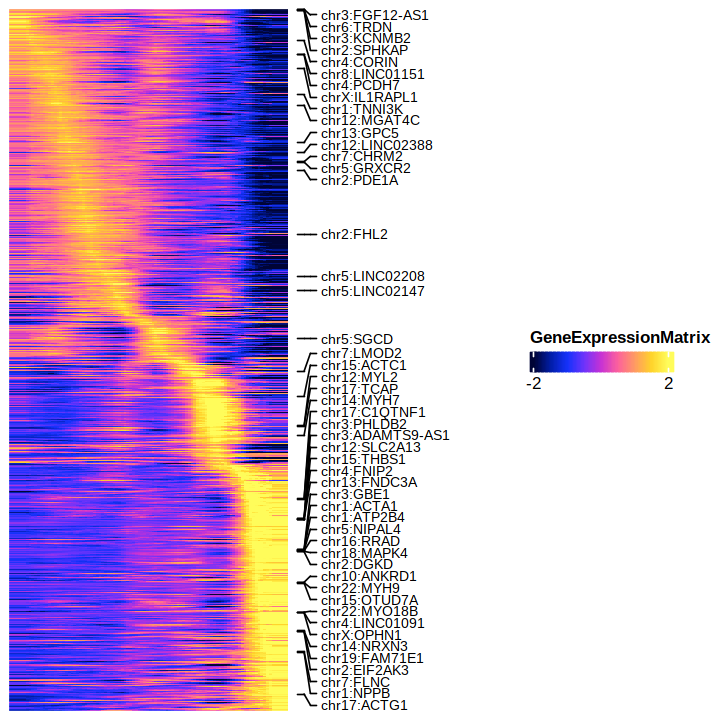

In [5]:
## create aggregated gene matrix
trajGEX <- getTrajectory(ArchRProj = proj,
                         name = "healthy_intermediate_damaged",
                         useMatrix = "GeneExpressionMatrix",
                         log2Norm = TRUE,
                        smoothWindow = 11)

ht <- plotTrajectoryHeatmap(trajGEX,
                        varCutOff = 0.9,
                        pal = paletteContinuous(set = "horizonExtra"),
                        limits = c(-2, 2))

options(repr.plot.height = 6, repr.plot.width = 6)

saveRDS(trajGEX, "../data/snATAC_healthy_intermediate_damaged/trajGEX.Rds")

ht

In [6]:
geneMatrix <- getMatrixFromProject(proj, useMatrix = "GeneExpressionMatrix")

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-1f9ca86e2c7f1c-Date-2022-02-17_Time-15-05-06.log
If there is an issue, please report to github with logFile!

2022-02-17 15:05:15 : Organizing colData, 0.153 mins elapsed.

2022-02-17 15:05:15 : Organizing rowData, 0.161 mins elapsed.

2022-02-17 15:05:15 : Organizing rowRanges, 0.162 mins elapsed.

2022-02-17 15:05:15 : Organizing Assays (1 of 1), 0.162 mins elapsed.

2022-02-17 15:05:26 : Constructing SummarizedExperiment, 0.334 mins elapsed.

2022-02-17 15:05:26 : Finished Matrix Creation, 0.347 mins elapsed.



In [7]:
groupMatRNA <- plotTrajectoryHeatmap(trajGEX,
                        varCutOff = 0.9,
                        pal = paletteContinuous(set = "horizonExtra"),
                        limits = c(-2, 2),
                           returnMatrix = TRUE)
geneSet <- geneMatrix@elementMetadata

rownames(geneSet) <- paste0(geneSet$seqnames, ":", geneSet$name)

geneSet <- geneSet[rownames(groupMatRNA), ]

geneStart <- GRanges(geneSet$seqnames, 
                   IRanges(geneSet$start, 
                           width = 1), 
                     name = geneSet$name, 
        idx = geneSet$idx)

seRNA <- SummarizedExperiment(assays = SimpleList(RNA = groupMatRNA), 
                              rowRanges = geneStart)

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1f9ca8291ac5b5-Date-2022-02-17_Time-15-05-26.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1f9ca8291ac5b5-Date-2022-02-17_Time-15-05-26.log



In [8]:
seRNA

class: RangedSummarizedExperiment 
dim: 1902 100 
metadata(0):
assays(1): RNA
rownames(1902): chr3:FGF12-AS1 chr6:TRDN ... chr3:ITGB5 chr1:MLLT11
rowData names(2): name idx
colnames(100): T.0_1 T.1_2 ... T.98_99 T.99_100
colData names(0):

In [9]:
## create aggregated gene matrix
trajPM <- getTrajectory(ArchRProj = proj,
                         name = "healthy_intermediate_damaged",
                         useMatrix = "PeakMatrix",
                         log2Norm = TRUE,
                        smoothWindow = 11)

trajPM

Creating Trajectory Group Matrix..

Smoothing...



class: SummarizedExperiment 
dim: 197282 100 
metadata(1): Params
assays(2): smoothMat mat
rownames(197282): chr1:817111_817611 chr1:827289_827789 ...
  chrX:155881042_155881542 chrX:155888158_155888658
rowData names(4): seqnames idx start end
colnames(100): T.0_1 T.1_2 ... T.98_99 T.99_100
colData names(0):

In [10]:
groupMatATAC <- plotTrajectoryHeatmap(trajPM,
                        varCutOff = 0,
                                      maxFeatures = 197282,
                        pal = paletteContinuous(set = "horizonExtra"),
                        limits = c(-2, 2),
                           returnMatrix = TRUE
                          )

nrow(groupMatATAC)
head(groupMatATAC)

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1f9ca84945f3d6-Date-2022-02-17_Time-15-05-52.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1f9ca84945f3d6-Date-2022-02-17_Time-15-05-52.log



[1] 197282

,T.0_1,T.1_2,T.2_3,T.3_4,T.4_5,T.5_6,T.6_7,T.7_8,T.8_9,T.9_10,⋯,T.90_91,T.91_92,T.92_93,T.93_94,T.94_95,T.95_96,T.96_97,T.97_98,T.98_99,T.99_100
chr1:178932083_178932583,0.9249132,0.9249132,0.9249132,0.9249132,0.9249132,0.9249132,0.8663188,0.7893783,0.7690651,0.6182954,⋯,-1.732605,-1.677360,-1.950821,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
chr18:27057325_27057825,0.9663470,0.9663470,0.9663470,0.9663470,0.9663470,0.9663470,0.9173514,0.9250077,0.8912536,0.9434207,⋯,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
chr7:153524062_153524562,1.3320189,1.3320189,1.3320189,1.3320189,1.3320189,1.3320189,1.2943085,1.1831367,1.2306833,1.2465597,⋯,-1.698772,-1.675831,-1.899478,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
chr2:128379074_128379574,1.5236834,1.5236834,1.5236834,1.5236834,1.5236834,1.5236834,1.2554330,1.2474874,1.1594163,1.0864132,⋯,-1.258139,-1.452785,-1.460389,-1.634659,-1.895818,-1.895818,-1.895818,-1.895818,-1.895818,-1.895818
chr10:35898682_35899182,1.3049005,1.3049005,1.3049005,1.3049005,1.3049005,1.3049005,1.1843445,1.2023059,1.1597799,1.2105356,⋯,-1.686218,-1.578941,-1.773782,-1.683527,-1.776507,-1.776507,-1.776507,-1.776507,-1.776507,-1.776507
chr2:20611251_20611751,0.9277188,0.9277188,0.9277188,0.9277188,0.9277188,0.9277188,0.8354226,0.8014462,0.8727055,0.7971658,⋯,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000


In [11]:
df_peak <- stringr::str_split_fixed(rownames(groupMatATAC), ":|-|_", 3)
head(df_peak)

peakSet <- GRanges(df_peak[, 1], IRanges(start = as.numeric(df_peak[, 2]),
                                           end = as.numeric(df_peak[, 3])))

seATAC <- SummarizedExperiment(assays = SimpleList(ATAC = groupMatATAC),
                               rowRanges = peakSet)

chr1,178932083,178932583
chr18,27057325,27057825
chr7,153524062,153524562
chr2,128379074,128379574
chr10,35898682,35899182
chr2,20611251,20611751


In [12]:
seATAC

class: RangedSummarizedExperiment 
dim: 197282 100 
metadata(0):
assays(1): ATAC
rownames(197282): chr1:178932083_178932583 chr18:27057325_27057825 ...
  chr9:99055252_99055752 chr4:6473688_6474188
rowData names(0):
colnames(100): T.0_1 T.1_2 ... T.98_99 T.99_100
colData names(0):

In [13]:
## find putative peak-to-gene
maxDist = 250000

o <- DataFrame(findOverlaps(resize(seRNA, 2 * maxDist + 1, "center"),
                            resize(rowRanges(seATAC), 1, "center"),
                            ignore.strand = TRUE))

o$distance <- distance(rowRanges(seRNA)[o[, 1]], 
                       rowRanges(seATAC)[o[, 2]])
colnames(o) <- c("B", "A", "distance")

df <- rowRanges(seATAC)[o$A, ]

o$gene <- rowData(seRNA)[o$B, ]$name
o$peak <- paste0(df@seqnames, "_",
                 as.data.frame(df@ranges)$start, "_",
                 as.data.frame(df@ranges)$end)

In [14]:
outATAC <- file.path(getOutputDirectory(proj), "Peak2GeneLinks", "seATAC-Group-KNN.rds")
outRNA <- file.path(getOutputDirectory(proj), "Peak2GeneLinks", "seRNA-Group-KNN.rds")

In [15]:
## compute correlation
o$Correlation <- rowCorCpp(as.integer(o$A), 
                           as.integer(o$B), 
                           assay(seATAC), 
                           assay(seRNA))

o$VarAssayA <- ArchR:::.getQuantiles(matrixStats::rowVars(assay(seATAC)))[o$A]
o$VarAssayB <- ArchR:::.getQuantiles(matrixStats::rowVars(assay(seRNA)))[o$B]
o$TStat <- (o$Correlation / sqrt((pmax(1-o$Correlation^2, 0.00000000000000001, na.rm = TRUE))/(ncol(seATAC)-2))) #T-statistic P-value

o$Pval <- 2 * pt(-abs(o$TStat), ncol(seATAC) - 2)
o$FDR <- p.adjust(o$Pval, method = "fdr")
out <- o[, c("A", "B", "Correlation", "FDR", "VarAssayA", 
        "VarAssayB", "distance")]
colnames(out) <- c("idxATAC", "idxRNA", "Correlation", "FDR", 
        "VarQATAC", "VarQRNA", "Distance")
mcols(peakSet) <- NULL
names(peakSet) <- NULL
metadata(out)$peakSet <- peakSet
metadata(out)$geneSet <- geneStart

out$gene <- o$gene
out$peak <- o$peak
  
out <- out[!is.na(out$FDR), ]

metadata(out)$seATAC <- outATAC
metadata(out)$seRNA <- outRNA

metadata(proj@peakSet)$Peak2GeneLinks <- out

In [16]:
head(out)

DataFrame with 6 rows and 9 columns
    idxATAC    idxRNA Correlation         FDR  VarQATAC   VarQRNA  Distance
  <integer> <integer>   <numeric>   <numeric> <numeric> <numeric> <integer>
1      7963         1  0.65330907 1.12900e-12  0.868250  0.649317      9173
2     13133         1  0.38969272 1.31197e-04  0.819000  0.649317    207619
3     20022         1  0.25527913 1.59851e-02  0.713699  0.649317     23039
4     20719         1  0.17310251 1.11631e-01  0.861300  0.649317    208302
5     20723         1  0.39403593 1.08039e-04  0.554354  0.649317    248956
6     20852         1  0.00539283 9.64601e-01  0.383872  0.649317    107052
       gene                   peak
    <array>            <character>
1 FGF12-AS1 chr3_192247211_19224..
2 FGF12-AS1 chr3_192445657_19244..
3 FGF12-AS1 chr3_192261077_19226..
4 FGF12-AS1 chr3_192446340_19244..
5 FGF12-AS1 chr3_192486994_19248..
6 FGF12-AS1 chr3_192130484_19213..

In [17]:
saveRDS(seATAC, file = outATAC)
saveRDS(seRNA, file = outRNA)

In [18]:
df_p2g <- out %>%
    as.data.frame() %>%
    subset(Correlation > 0) %>%
    subset(Distance > 2000 & FDR < 1e-04)

In [19]:
length(unique(df_p2g$gene))

[1] 1827

In [20]:
## update gene name and peak name
df_peak <- stringr::str_split_fixed(df_p2g$peak, "_", 3)
df_p2g$peak_name <- paste0(df_peak[, 1], ":", df_peak[, 2], "_", df_peak[, 3])
df_p2g$gene_name <- paste0(df_peak[, 1], ":", df_p2g$gene)

In [21]:
head(df_p2g)

,idxATAC,idxRNA,Correlation,FDR,VarQATAC,VarQRNA,Distance,gene,peak,peak_name,gene_name
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
1,7963,1,0.6533091,1.129005e-12,0.8682495,0.6493165,9173,FGF12-AS1,chr3_192247211_192247711,chr3:192247211_192247711,chr3:FGF12-AS1
7,22801,1,0.4280020,2.138076e-05,0.4408613,0.6493165,29949,FGF12-AS1,chr3_192207587_192208087,chr3:192207587_192208087,chr3:FGF12-AS1
9,45359,1,0.5528661,9.375059e-09,0.9218023,0.6493165,115679,FGF12-AS1,chr3_192121857_192122357,chr3:192121857_192122357,chr3:FGF12-AS1
10,66048,1,0.5318030,4.336000e-08,0.4062662,0.6493165,12940,FGF12-AS1,chr3_192224596_192225096,chr3:192224596_192225096,chr3:FGF12-AS1
32,847,2,0.4519074,6.120493e-06,0.8739520,0.3002103,195306,TRDN,chr6_123441286_123441786,chr6:123441286_123441786,chr6:TRDN
36,2028,2,0.5527832,9.433825e-09,0.6125039,0.3002103,170851,TRDN,chr6_123465741_123466241,chr6:123465741_123466241,chr6:TRDN


In [22]:
trajPM2 <- trajPM[df_p2g$peak_name, ]
trajGEX2 <- trajGEX[df_p2g$gene_name, ]

In [23]:
trajPM2
trajGEX2

saveRDS(trajPM2, "../data/snATAC_healthy_intermediate_damaged/p2g_trajPM2.Rds")
saveRDS(trajGEX2, "../data/snATAC_healthy_intermediate_damaged/p2g_trajGEX2.Rds")

class: SummarizedExperiment 
dim: 35056 100 
metadata(1): Params
assays(2): smoothMat mat
rownames(35056): chr3:192247211_192247711 chr3:192207587_192208087 ...
  chr1:150922381_150922881 chr1:151033957_151034457
rowData names(4): seqnames idx start end
colnames(100): T.0_1 T.1_2 ... T.98_99 T.99_100
colData names(0):

class: SummarizedExperiment 
dim: 35056 100 
metadata(1): Params
assays(2): smoothMat mat
rownames(35056): chr3:FGF12-AS1 chr3:FGF12-AS1 ... chr1:MLLT11
  chr1:MLLT11
rowData names(6): seqnames idx ... name strand
colnames(100): T.0_1 T.1_2 ... T.98_99 T.99_100
colData names(0):

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1f9ca8412dee8f-Date-2022-02-17_Time-15-06-09.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1f9ca8412dee8f-Date-2022-02-17_Time-15-06-09.log

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1f9ca83fde9bd4-Date-2022-02-17_Time-15-06-10.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1f9ca83fde9bd4-Date-2022-02-17_Time-15-06-10.log



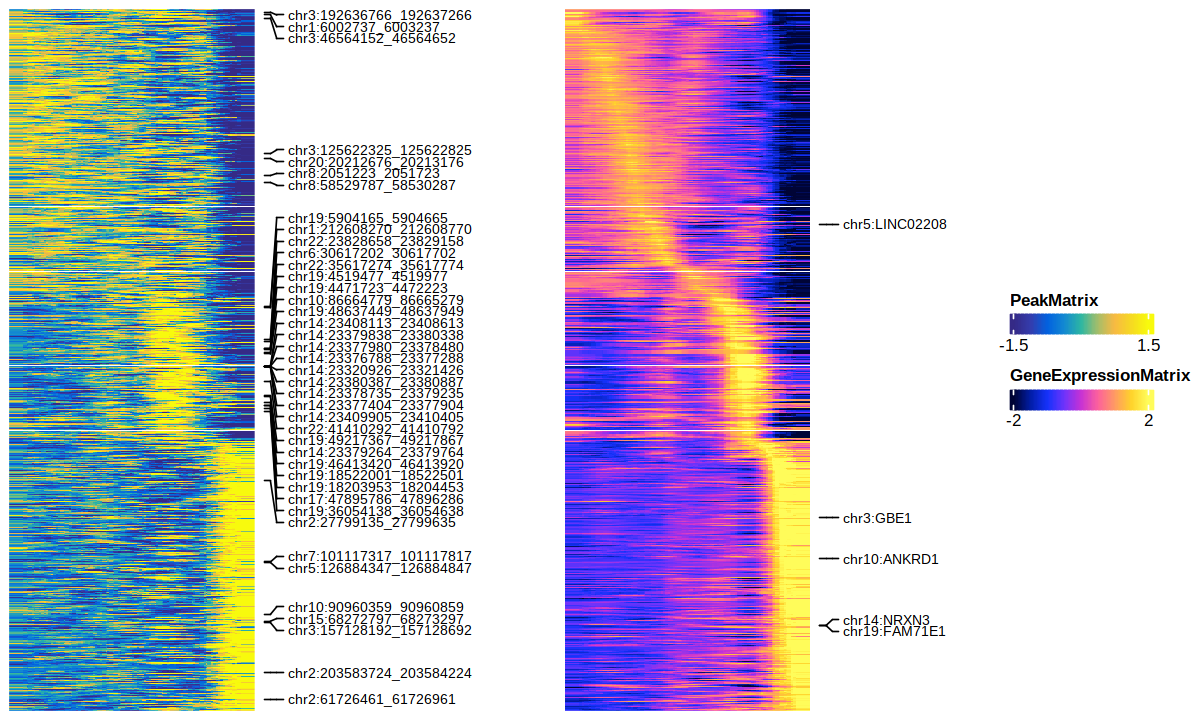

In [24]:
ht1 <- plotTrajectoryHeatmap(trajPM2, 
                            pal = paletteContinuous(set = "blueYellow"),
                            varCutOff = 0,
                            #limits = c(-2, 2),
                             maxFeatures = 100000,
                             rowOrder = 1:nrow(df_p2g))

ht2 <- plotTrajectoryHeatmap(trajGEX2, 
                            pal = paletteContinuous(set = "horizonExtra"),
                            varCutOff = 0,
                            limits = c(-2, 2),
                             maxFeatures = 100000,
                             rowOrder = 1:nrow(df_p2g))

options(repr.plot.height = 6, repr.plot.width = 10)

ht1 + ht2

In [25]:
write.csv(out, file = "../data/snATAC_healthy_intermediate_damaged/p2g_all.csv")
write.csv(df_p2g, file = "../data/snATAC_healthy_intermediate_damaged/p2g.csv")

In [26]:
saveArchRProject(ArchRProj = proj, 
                 load = FALSE)

Saving ArchRProject...



In [27]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.5 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /home/rs619065/miniconda3/envs/r-4.1/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] circlize_0.4.13             ComplexHeatmap_2.10.0      
 [3] ggrepel_0.9.1               phateR_1.0.7               
 [5] Ipaper_0.1.8                ggpubr_0.4.0               
 [7] Nebulosa_1.4.0              patchwork_1.1.1            
 [9] cowp